##### INFORMACIÓN RELEVANTE

**VARIABLES DE LA BASE DE DATOS**

**1. Active_energy:** Energía activa entregada (kWh)
* Representa la cantidad de energía eléctrica real entregada en un periodo de tiempo específico.
* Es la energía que realiza trabajo efectivo, como encender luces, hacer funcionar motores o calentar dispositivos.
* Se mide en kilovatios-hora

**2. Reactive_energy:** Energía reactiva entregada (kVarh)
* Indica la cantidad de energía intercambiada entre la fuente de energía y una carga sin realizar trabajo útil. 
* Esta energía se debe principalmente a la capacitancia e inductancia de los equipos eléctricos y no produce trabajo real, pero es esencial para mantener la calidad del voltaje en el sistema eléctrico.
* Se mide en kilovatios-amperios-reativos-hora

**3. Voltaje:**
* Es la diferencia de potencial eléctrico
* Es una medida de la fuerza electromotriz que impulsa el flujo de corriente eléctrica a través de un conuctor.
* Es la energía por unidad de carga eléctrica que proporciona la capacidad de realizar trabajo eléctrico.

**Voltaje_FA vs Voltaje_FC:**
* ...

##### LIBRERÍAS

In [1]:
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

##### CONSOLIDACIÓN DE LOS DATOS DISPONIBLES

In [2]:
# Ruta del directorio que contiene los archivos de Excel
directorio = os.getcwd() + "/Datos"

# Obtener la lista de archivos en el directorio
archivos_excel = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.csv')]

# Lista para almacenar los DataFrames de cada archivo
dataframes = []

# Iterar sobre los archivos de Excel en el directorio
for archivo in archivos_excel:
    ruta_archivo = os.path.join(directorio, archivo)
    df = pd.read_csv(ruta_archivo)
    
    # Agregar la columna Cliente_ID utilizando expresión regular para extraer el número
    Cliente_ID = re.search(r'\d+', archivo).group()
    df['Cliente_ID'] = Cliente_ID
    df['Cliente_ID'] = df['Cliente_ID'].astype('int64')
    
    # Validar que las columnas requeridas estén presentes en el DataFrame
    if all(col in df.columns for col in ["Fecha", "Active_energy", "Reactive_energy", "Voltaje_FA", "Voltaje_FC", "Cliente_ID"]):
        dataframes.append(df)
    else:
        print(f"Faltan columnas en el archivo {archivo}")

# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)

# Leer el archivo 'sector_economico_clientes.xlsx'
df_sector = pd.read_excel('Datos/sector_economico_clientes.xlsx')

# Renombrar columnas
df_sector = df_sector.rename(columns={'Cliente:':'Cliente_ID', 'Sector Económico:':'Sector_Economico'})

# Actualizar los valores de la columna Cliente_ID
df_sector['Cliente_ID'] = pd.to_numeric(df_sector['Cliente_ID'].str.replace('Cliente ', ''))

# Fusionar los DataFrames por 'Cliente_ID' y agregar la columna 'Sector_Economico'
df_resultado = pd.merge(df_final, df_sector, on='Cliente_ID')

# Mostrar el DataFrame resultante
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...
...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces


In [22]:
df_resultado[['Active_energy','Reactive_energy','Voltaje_FA','Voltaje_FC']].describe().T

,count,mean,std,min,25%,50%,75%,max
Active_energy,463425.0,1.472050,1.718780,-1.329018,0.242788,0.810771,1.992488,14.622644
Reactive_energy,463425.0,0.873086,1.158846,0.000000,0.112832,0.380650,1.222834,11.135141
Voltaje_FA,463425.0,1420.188470,766.299118,0.031000,719.462874,1625.493463,2037.276385,4266.229746
Voltaje_FC,463425.0,1438.515836,746.447449,0.031000,748.148254,1634.696089,2040.554497,4399.038932


### Missing values

In [4]:
def generar_resumen_missing_values(dataframe):
    # Calcula la cantidad de valores faltantes por columna
    missing_values = dataframe.isnull().sum()

    # Calcula el porcentaje de valores faltantes por columna
    porcentaje_missing_values = (missing_values / len(dataframe)) * 100

    # Crea un DataFrame con la información recopilada
    resumen_missing_values = pd.DataFrame({
        'Valores Faltantes': missing_values,
        'Porcentaje Missing Values': porcentaje_missing_values
    })

    return resumen_missing_values
missing=generar_resumen_missing_values(df_resultado)
missing

,Valores Faltantes,Porcentaje Missing Values
Fecha,0,0.0
Active_energy,0,0.0
Reactive_energy,0,0.0
Voltaje_FA,0,0.0
Voltaje_FC,0,0.0
Cliente_ID,0,0.0
Sector_Economico,0,0.0


### Outliers

In [5]:
variables_numericas = df_resultado.select_dtypes(include='number')

def detectar_outliers(dataframe):
    outliers = pd.DataFrame()

    for columna in dataframe.columns:
        # Calcular el primer y tercer cuartil
        q1 = dataframe[columna].quantile(0.25)
        q3 = dataframe[columna].quantile(0.75)

        # Calcular el rango intercuartil (IQR)
        iqr = q3 - q1

        # Definir los límites para identificar outliers
        limite_inferior = q1 - 1.5 * iqr
        limite_superior = q3 + 1.5 * iqr

        # Filtrar los outliers y almacenarlos en el DataFrame de outliers
        outliers[columna] = dataframe[(dataframe[columna] < limite_inferior) | (dataframe[columna] > limite_superior)][columna]

    # Crear un DataFrame con el número de outliers y el valor máximo por columna
    resumen_outliers = pd.DataFrame({
        'Numero de Outliers': outliers.count(),
        'Valor Maximo': dataframe.max(),
        'Valor Minimo': dataframe.min()
    })

    return resumen_outliers


outliers=detectar_outliers(variables_numericas)
outliers

,Numero de Outliers,Valor Maximo,Valor Minimo
Active_energy,31703,14.622644,-1.329018
Reactive_energy,12969,11.135141,0.000000
Voltaje_FA,1,4266.229746,0.031000
Voltaje_FC,0,4399.038932,0.031000
Cliente_ID,0,30.000000,1.000000


### Correlation Matrix

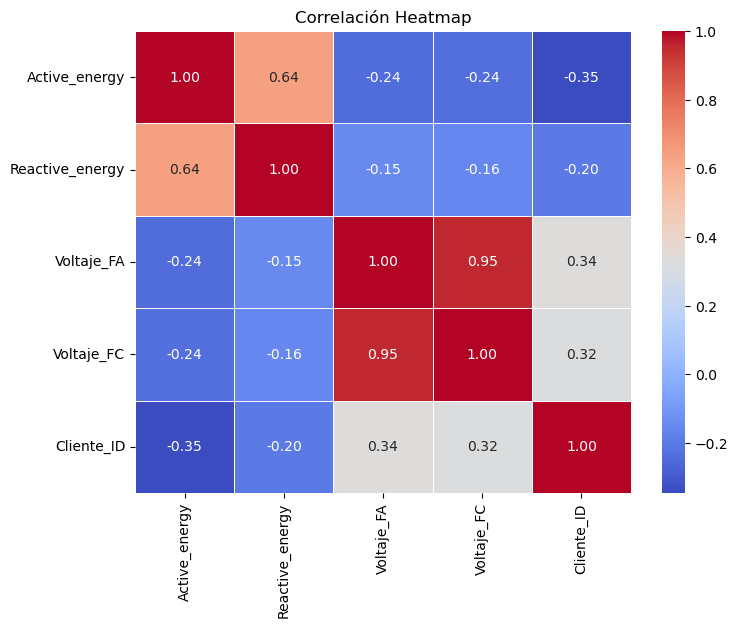

In [6]:
correlation_matrix =  df_resultado.select_dtypes(include='number').corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Correlación Heatmap')

# Mostrar el gráfico
plt.show()

### Transformación variables

#### Codificación de variable Sector_Económico

In [7]:
# Agrupar por 'Sector_Economico' 
registros_por_sector = df_resultado.groupby('Sector_Economico')['Cliente_ID'].nunique().reset_index()

registros_por_sector = registros_por_sector.rename(columns={'Cliente_ID': 'Conteo_Clientes_Unicos'})

display(registros_por_sector)


,Sector_Economico,Conteo_Clientes_Unicos
0,"Captación, tratamiento y distribución de agua",5
1,Cultivo de Hortalizas,5
2,"Cultivo de hortalizas y melones, raíces y tubé...",1
3,Cultivo de otros frutos y nueces de árboles y ...,4
4,Cultivo de Árboles Frutales y Nueces,5
5,Elaboración de cacao y chocolate y de producto...,5
6,Venta al por mayor de metales y minerales meta...,5


In [8]:
label_encoder = LabelEncoder()

# Aplicar la transformación a la columna 'Sector_Economico'
df_resultado['Sector_Economico_Num'] = label_encoder.fit_transform(df_resultado['Sector_Economico'])

# Mostrar las primeras filas del DataFrame con la nueva variable numérica
df_resultado


,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5
...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4


In [9]:
df_sectores_unicos = df_resultado[['Sector_Economico', 'Sector_Economico_Num']].drop_duplicates()
df_sectores_unicos

,Sector_Economico,Sector_Economico_Num
0,Elaboración de cacao y chocolate y de producto...,5
19681,Cultivo de Árboles Frutales y Nueces,4
39362,Cultivo de otros frutos y nueces de árboles y ...,3
64777,"Cultivo de hortalizas y melones, raíces y tubé...",2
106777,"Captación, tratamiento y distribución de agua",0
223958,Cultivo de Hortalizas,1
268583,Venta al por mayor de metales y minerales meta...,6


### Adición de nueva información

#### Hora

In [10]:
# Convertir la columna 'Fecha' a tipo datetime si aún no lo está
df_resultado['Fecha'] = pd.to_datetime(df_resultado['Fecha'])

# Crear una nueva columna 'Hora' que contiene la hora de la fecha
df_resultado['Hora'] = df_resultado['Fecha'].dt.hour

# Mostrar las primeras filas del DataFrame con la nueva columna 'Hora'
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num,Hora
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5,0
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5,1
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5,2
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5,3
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5,4
...,...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4,20
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4,21
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4,22
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4,23


#### Día de la semana

In [11]:
# Convertir la columna 'Fecha' a tipo datetime si aún no lo está
df_resultado['Fecha'] = pd.to_datetime(df_resultado['Fecha'])

# Crear una nueva columna 'Dia_Semana_Num' que contiene el día de la semana como número
df_resultado['Dia_Semana_Num'] = df_resultado['Fecha'].dt.dayofweek

# Mostrar las primeras filas del DataFrame con la nueva columna 'Dia_Semana_Num'
df_resultado

,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,Cliente_ID,Sector_Economico,Sector_Economico_Num,Hora,Dia_Semana_Num
0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,Elaboración de cacao y chocolate y de producto...,5,0,4
1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,Elaboración de cacao y chocolate y de producto...,5,1,4
2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,Elaboración de cacao y chocolate y de producto...,5,2,4
3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,Elaboración de cacao y chocolate y de producto...,5,3,4
4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,Elaboración de cacao y chocolate y de producto...,5,4,4
...,...,...,...,...,...,...,...,...,...,...
463420,2023-03-31 20:00:00,0.231000,0.309493,1343.358528,1288.567372,9,Cultivo de Árboles Frutales y Nueces,4,20,4
463421,2023-03-31 21:00:00,0.041937,0.314091,1050.653622,1266.553989,9,Cultivo de Árboles Frutales y Nueces,4,21,4
463422,2023-03-31 22:00:00,0.231000,0.266937,1104.985834,991.259378,9,Cultivo de Árboles Frutales y Nueces,4,22,4
463423,2023-03-31 23:00:00,0.150296,0.312547,1284.048639,1091.283710,9,Cultivo de Árboles Frutales y Nueces,4,23,4


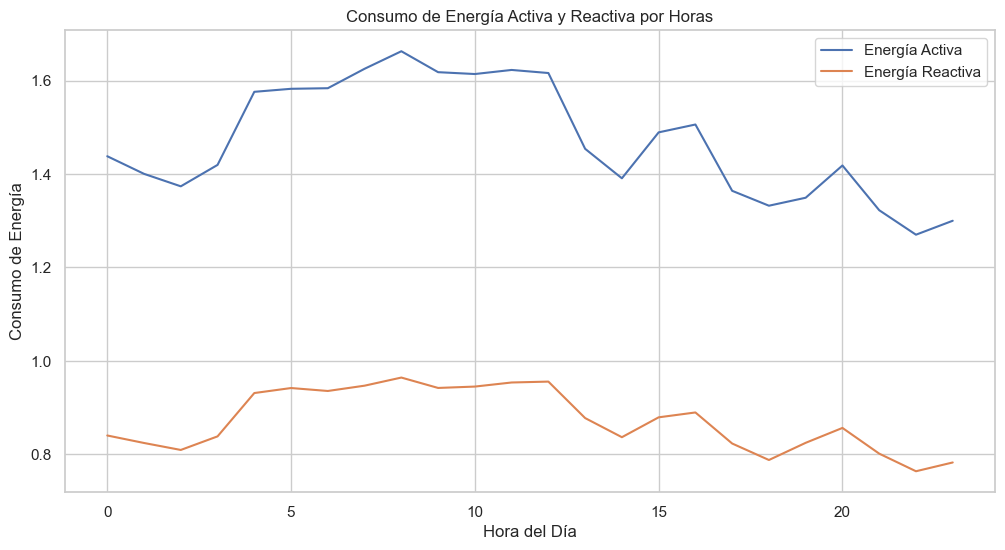

In [12]:

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura y ejes 
plt.figure(figsize=(12, 6))

# Grafica
sns.lineplot(x='Hora', y='Active_energy', data=df_resultado, label='Energía Activa', ci=None)
sns.lineplot(x='Hora', y='Reactive_energy', data=df_resultado, label='Energía Reactiva', ci=None)

plt.title('Consumo de Energía Activa y Reactiva por Horas')
plt.xlabel('Hora del Día')
plt.ylabel('Consumo de Energía')

plt.legend()

plt.show()


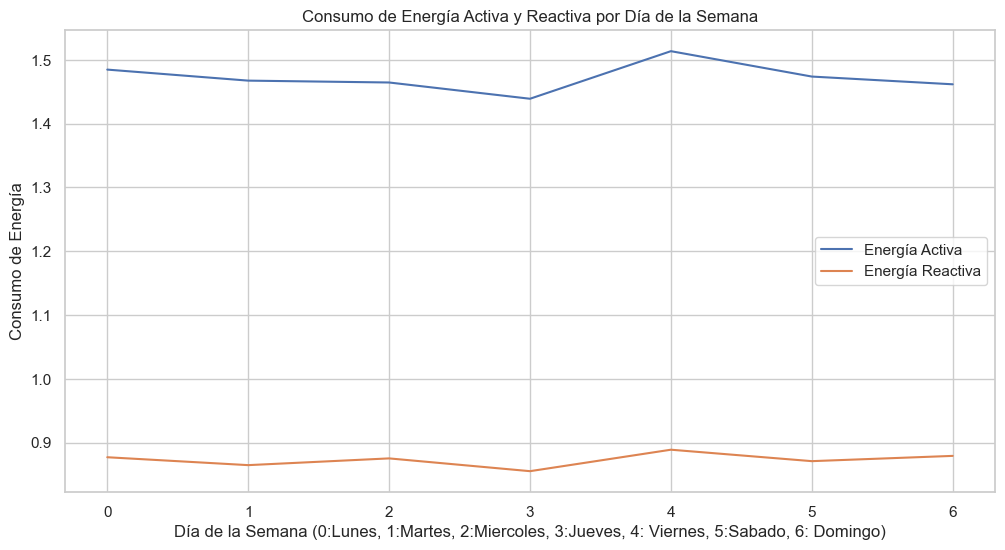

In [13]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura y ejes 
plt.figure(figsize=(12, 6))

# Grafica
sns.lineplot(x='Dia_Semana_Num', y='Active_energy', data=df_resultado, label='Energía Activa', ci=None)
sns.lineplot(x='Dia_Semana_Num', y='Reactive_energy', data=df_resultado, label='Energía Reactiva', ci=None)

plt.title('Consumo de Energía Activa y Reactiva por Día de la Semana')
plt.xlabel('Día de la Semana (0:Lunes, 1:Martes, 2:Miercoles, 3:Jueves, 4: Viernes, 5:Sabado, 6: Domingo)')
plt.ylabel('Consumo de Energía')

plt.legend()

plt.show()


#### APLICANDO PCA A LOS DATOS

Varianza explicada por cada componente: [0.55645299 0.34393952]


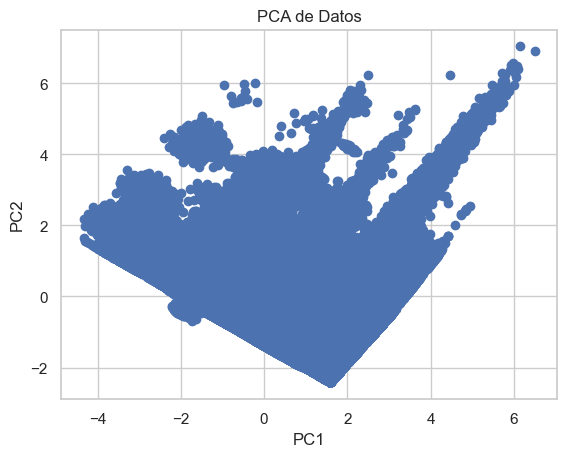

In [16]:
# Establecer las características que deseas incluir en el análisis PCA
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC']

# Separar las características del DataFrame
X = df_resultado[features]

# Estandarizar las características
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Inicializar el objeto PCA con el número de componentes deseados
n_components = 2  # Puedes ajustar este número según tus necesidades
pca = PCA(n_components=n_components)

# Aplicar PCA a los datos estandarizados
principal_components = pca.fit_transform(X_std)

# Crear un nuevo DataFrame con los componentes principales y otras columnas relevantes
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Explorar la varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance_ratio)

# Graficar los datos en el espacio de las componentes principales
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA de Datos')
plt.show()


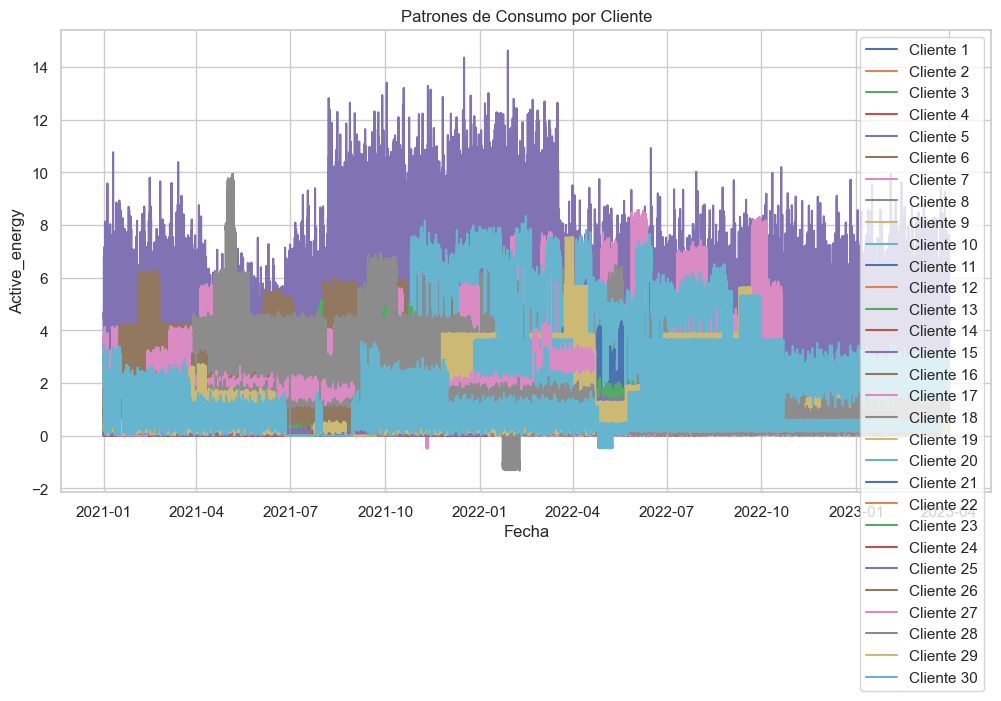

In [26]:
# Graficar patrones de consumo para cada cliente
plt.figure(figsize=(12, 6))
for cliente_id, datos_cliente in df_resultado.groupby('Cliente_ID'):
    plt.plot(datos_cliente['Fecha'], datos_cliente['Active_energy'], label=f'Cliente {cliente_id}')

plt.title('Patrones de Consumo por Cliente')
plt.xlabel('Fecha')
plt.ylabel('Active_energy')
plt.legend()
plt.show()


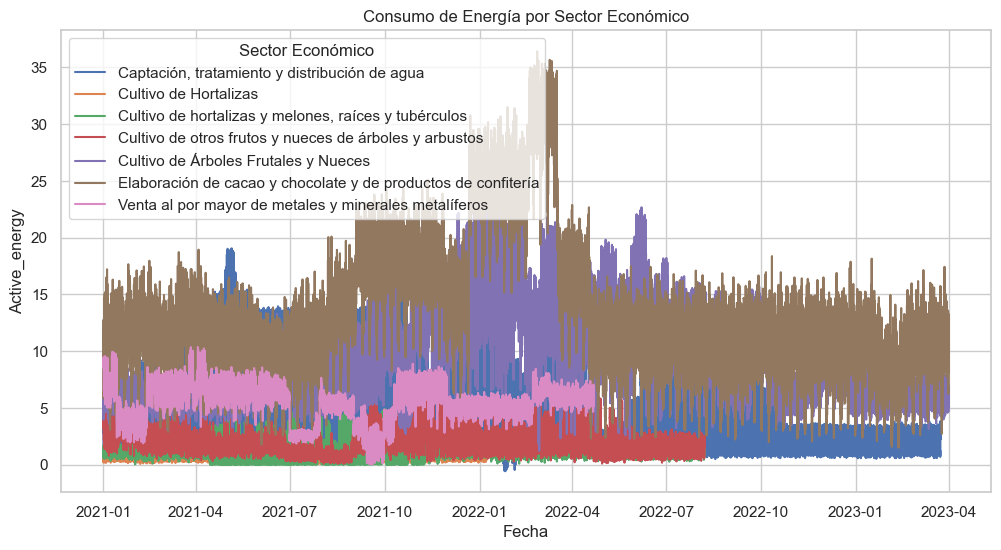

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar por 'Sector_Economico' y 'Fecha' y calcular la suma de 'Active_energy'
grouped_sector_df = df_resultado.groupby(['Sector_Economico', 'Fecha'])['Active_energy'].sum().reset_index()

# Graficar el consumo de energía por sector económico
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_sector_df, x='Fecha', y='Active_energy', hue='Sector_Economico')
plt.title('Consumo de Energía por Sector Económico')
plt.xlabel('Fecha')
plt.ylabel('Active_energy')
plt.legend(title='Sector Económico', loc='upper left')
plt.show()
